<a href="https://colab.research.google.com/github/taniyasinghsisodia/Deep-Learning-Projects/blob/master/Multiclass_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Libraries

In [1]:
import numpy as np
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

!pip install transformers
from transformers import RobertaTokenizer, TFAutoModel, AdamWeightDecay 

import tensorflow as tf

     |████████████████████████████████| 2.3MB 7.5MB/s 
     |████████████████████████████████| 901kB 46.7MB/s 
     |████████████████████████████████| 3.3MB 48.0MB/s 


####Load Dataset


**Dataset Link :** https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news

**Modification of dataset** : Change categorical text values to numerical values

In [2]:
def modify_df(dataset):
    df = dataset.copy()

    df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 'negative' else x)
    df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'neutral' else x)
    df['sentiment'] = df['sentiment'].apply(lambda x: 2 if x == 'positive' else x)

    return df 


def df_info(df,name):
    negative = df[df.sentiment == 0].shape[0]
    neutral = df[df.sentiment == 1].shape[0]
    positive = df[df.sentiment == 2].shape[0]    

    print(f"\n{name} -----> shape : {df.shape}")
    print(f"{name} -----> negative: {negative}, neutral: {neutral}, positive: {positive}\n")

    return None  

In [4]:
df = pd.read_csv("/content/all-data.csv", header=None, sep=',', names=['sentiment', 'text'], engine='python')

print(df.head())

#df = modify_df(df)
#df_info(df,"original")

  sentiment                                               text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [5]:
df = modify_df(df)

In [6]:
df.head()

,sentiment,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


The dataset is highly imbalanced. Very few negatives. More neutral than positives.

**Split Dataset**: Split dataset into 3 sets : Train(90%), valid(5%), test(5%)

In [7]:
train, valid_test = train_test_split(df, test_size = 0.1, shuffle=True)
valid, test = train_test_split(valid_test, test_size = 0.5, shuffle=True)

df_info(train, "train")
df_info(valid, "valid")
df_info(test, "test")


x_train = train[["text"]]
y_train = train[["sentiment"]]

x_valid = valid[["text"]]
y_valid = valid[["sentiment"]]


x_test = test[["text"]]
y_test = test[["sentiment"]]


train -----> shape : (4361, 2)
train -----> negative: 537, neutral: 2594, positive: 1230


valid -----> shape : (242, 2)
valid -----> negative: 28, neutral: 142, positive: 72


test -----> shape : (243, 2)
test -----> negative: 39, neutral: 143, positive: 61



Finding out how much max length of the sequences(texts) are.

In [8]:
x_train["text"]

4687    ( ADP News ) - Jan 22 , 2009 - Finnish mobile ...
368     Sales of security and system packaging increas...
3147    TeliaSonera said about $ 100 million will be i...
1228    Furthermore , our fully electrically driven cr...
1168    Also , Technopolis plans to build a 100 millio...
                              ...                        
1989    `` Uncommonly weak snow conditions in nearly e...
273     Profit for the period was EUR 9.8 mn , up from...
2644    The lay-offs will affect 240 people out of the...
2503    Latvia 's Stockmann shopping mall is a subsidi...
4401    In Q1 of 2009 , the company 's result before t...
Name: text, Length: 4361, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


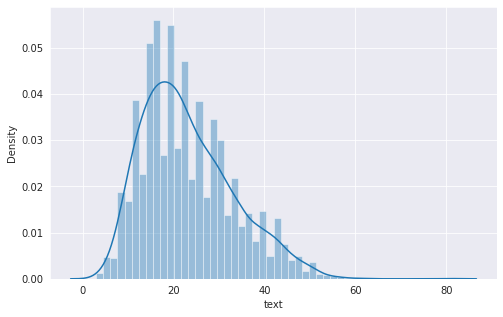

In [9]:
seqlen = x_train["text"].apply(lambda x: len(x.split()))

sns.set_style("darkgrid")
plt.figure(figsize=(8,5))
sns.distplot(seqlen)

#### Preprocessings

Some common preprocessing for the texts.

In [10]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def preprocess_text(text):
    def clean_text(x):
        x = str(x)
        for punct in puncts:
            if punct in x:
                x = x.replace(punct, f' {punct} ')
        return x

    def clean_numbers(x):
        if bool(re.search(r'\d', x)):
            x = re.sub('[0-9]{5,}', '#####', x)
            x = re.sub('[0-9]{4}', '####', x)
            x = re.sub('[0-9]{3}', '###', x)
            x = re.sub('[0-9]{2}', '##', x)
        return x
    
    text = text.lower()
    text = clean_text(text)
    text = clean_numbers(text)

    return text


In [11]:
def preprocess(df, text_col_name):

    # lower and clean text
    df[text_col_name] = df[text_col_name].apply(lambda x: preprocess_text(x))

    # fill up the missing values
    df[text_col_name] = df[text_col_name].fillna("_##_")

    return df

In [12]:
x_train = preprocess(x_train.copy(), "text")
x_valid = preprocess(x_valid.copy(), "text")

print(x_train.head())

                                                   text
4687   (  adp news  )   -  jan ##  ,  ####  -  finni...
368   sales of security and system packaging increas...
3147  teliasonera said about  $  ### million will be...
1228  furthermore  ,  our fully electrically driven ...
1168  also  ,  technopolis plans to build a ### mill...


####Tokenization with RoBERTa Tokenizer


In [13]:
SEQ_LEN = 80

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [20]:
def tokenize(df):
    input_ids =  []
    attention_masks =  []
    
    for i, text in enumerate(df["text"]):
        tokens = tokenizer.encode_plus(text, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')   
         
        input_ids.append(np.asarray(tokens["input_ids"]).reshape(SEQ_LEN,))
        attention_masks.append(np.asarray(tokens["attention_mask"]).reshape(SEQ_LEN,))

    return (np.asarray(input_ids), np.asarray(attention_masks))

train_input_ids, train_attention_masks = tokenize(x_train)
valid_input_ids, valid_attention_masks = tokenize(x_valid)

print(train_input_ids[0])

[    0    36  1437  2329   642   340  1437  4839  1437  1437   111  1437
 10408 47385  1437  2156  1437   849 48134  1437   111  1437  8746   282
  1173  1830  4247  4403   295 43946 23136   267  1437    36  1437  1021
 42385  1437  4832  1437   295  1638   134   705  1437  4839  1437    26
   452    63  1633  1963  8065     7   364   710   195   325  1437    36
  1437   201   417   231   479   195   741   282  1437  4839  1437    13
   849 48134    31   364   710   290   325     2]


#### One hot encoding for the labels

In [21]:
def one_encode_labels(df):
    sentiment_values = set(df["sentiment"].values)
    labels = []
    for index, row in df.iterrows():
        label = np.zeros((len(sentiment_values)))
        label[row["sentiment"]] = 1 
        labels.append(label)
    labels = np.asarray(labels)
    return labels

In [24]:
# y_train = one_encode_labels(y_train)
# y_valid = one_encode_labels(y_valid)

# print(y_train[0])

#### Model Defining


In [23]:
roberta = TFAutoModel.from_pretrained("roberta-base")

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [25]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = roberta(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.LSTM(128)(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Activation("relu")(X)
X = tf.keras.layers.Dense(768)(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 80)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model_1 (TFRobertaMo TFBaseModelOutputWit 124645632   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          459264      tf_roberta_model_1[0][0]   

#### Compile and training of model

In [26]:
optimizer = AdamWeightDecay(2e-03, beta_1=0.8, beta_2=0.9, weight_decay_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [27]:
history = model.fit((train_input_ids, train_attention_masks),y_train, validation_data=((valid_input_ids,valid_attention_masks), y_valid), epochs=2, batch_size=32)

Epoch 1/2
137/137 [==============================] - 69s 209ms/step - loss: 1.1864 - accuracy: 0.5708 - val_loss: 0.9160 - val_accuracy: 0.6570
Epoch 2/2
137/137 [==============================] - 26s 190ms/step - loss: 0.7493 - accuracy: 0.6548 - val_loss: 0.7868 - val_accuracy: 0.5744


#### Prediction and classification result

In [28]:
tokenizer =  RobertaTokenizer.from_pretrained("roberta-base")

# predictions need to go through same preprocessings
def prep_data(text):
    text = preprocess_text(text)

    tokens = tokenizer.encode_plus(text, max_length=80,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')

    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

def predict(text):
    in_tensor = prep_data(text)
    probs = model.predict(in_tensor)[0]
    return (np.argmax(probs))

In [29]:
predictions = np.asarray(x_test["text"].apply(lambda x: predict(x)))
test_vals = np.asarray(y_test["sentiment"])

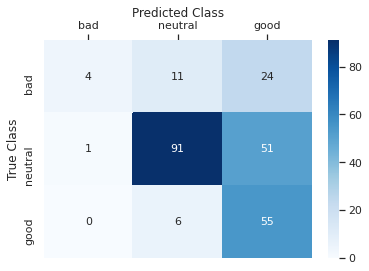

              precision    recall  f1-score   support

         bad     0.8000    0.1026    0.1818        39
     neutral     0.8426    0.6364    0.7251       143
        good     0.4231    0.9016    0.5759        61

    accuracy                         0.6173       243
   macro avg     0.6886    0.5469    0.4943       243
weighted avg     0.7304    0.6173    0.6005       243



In [30]:
confusion = confusion_matrix(test_vals, predictions)
# plot confusion matrix
sns.set(font_scale=1.0)
labels = ["bad", "neutral", "good"]
ax = sns.heatmap(confusion, annot=True, annot_kws={"size": 11}, fmt='d', vmin = 0, cmap='Blues', yticklabels=labels, xticklabels=labels)
ax.set_xlabel('Predicted Class')   
ax.set_ylabel('True Class')   
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.show()

# print classification report
report = classification_report(test_vals, predictions, digits = 4, output_dict=False, target_names=["bad", "neutral", "good"],)
print(report)

# predict

In [32]:
data2 = "the situation is under control we all are celebrating festival today"

In [33]:
pre = np.asarray(predict(data2))

In [34]:
predict(data2)

1

In [35]:
pre

array(1)

# save model

In [ ]:
model.save('/content')
loaded_model = tf.keras.models.load_model('/content')

#test

In [ ]:
import pandas as pd

# Create a Dataframe from CSV
#root = "drive/MyDrive/Tensorflow Projects/Multiclass Sentiment Classification on Financial News/"
df = pd.read_csv("/content/all-data.csv", header=None, sep=',', names=['sentiment', 'text'], engine='python')

print(df.head())

#df = modify_df(df)
#df_info(df,"original")



  sentiment                                               text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [ ]:
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
# Drop via logic (similar to a SQL 'WHERE' clause)
df2 = df[df.sentiment != 'neutral']

In [ ]:
dfs = df.query("sentiment not in ['neutral', 'positive']")

In [ ]:
dfs.head()

,sentiment,text
2,negative,The international electronic industry company ...
415,negative,A tinyurl link takes users to a scamming site ...
421,negative,"Compared with the FTSE 100 index , which rose ..."
423,negative,"Compared with the FTSE 100 index , which rose ..."
500,negative,One of the challenges in the oil production in...
